In [1]:
%matplotlib inline


`Learn the Basics <intro.html>`_ ||
**Quickstart** ||
`Tensors <tensorqs_tutorial.html>`_ ||
`Datasets & DataLoaders <data_tutorial.html>`_ ||
`Transforms <transforms_tutorial.html>`_ ||
`Build Model <buildmodel_tutorial.html>`_ ||
`Autograd <autogradqs_tutorial.html>`_ ||
`Optimization <optimization_tutorial.html>`_ ||
`Save & Load Model <saveloadrun_tutorial.html>`_

Quickstart
===================
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

Working with data
-----------------
PyTorch has two `primitives to work with data <https://pytorch.org/docs/stable/data.html>`_:
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.




In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.nn.functional as F


We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



Read more about `loading data in PyTorch <data_tutorial.html>`_.




### Low Rank Toy Problem ###
1) Create Data

In [3]:
# Import libraries
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
# create custom dataset class
class CustomTextDataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels
        self.text = text

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.text[idx]
        sample = {"X_data": data, "Y_data": label}
        return sample

In [4]:
def target_fun(x):
    return x**3

In [5]:
problem_dim=5
x = 0.5*np.ones(shape=(1,problem_dim))#np.random.rand(2,problem_dim)
y = target_fun(x)#np.linalg.norm(x,axis=1,keepdims=True)*np.linalg.norm(x,axis=1,keepdims=True)

### store for sanity checks
x_store = x
y_store = y
#y = -y*y
x_data = list(x)
y_data = list(y)
print(x.shape)
print(y.shape)
# create Pandas DataFrame
text_labels_df = pd.DataFrame({'X_Values': x_data, 'Y_Values': y_data})

# define data set object
ToyDataset = CustomTextDataset(text_labels_df['X_Values'], text_labels_df['Y_Values'])

# Display image and label.
#print('\nFirst iteration of data set: ', next(iter(TD)), '\n')

# Print how many items are in the data set
#print('Length of data set: ', len(TD), '\n')

# Print entire data set
#print('Entire data set: ', list(DataLoader(TD)), '\n')

## test data

#x = np.random.rand(1000,problem_dim)
y = target_fun(x)#np.linalg.norm(x,axis=1,keepdims=True)*np.linalg.norm(x,axis=1,keepdims=True)
#y = -y*y
x_data_test = list(x)
y_data_test = list(y)
#print(x_data)
#print(y_data)
# create Pandas DataFrame
text_labels_df = pd.DataFrame({'X_Values': x_data_test, 'Y_Values': y_data_test})

# define data set object
ToyDataset_Test = CustomTextDataset(text_labels_df['X_Values'], text_labels_df['Y_Values'])



(1, 5)
(1, 5)


In [6]:
x
y

array([[0.125, 0.125, 0.125, 0.125, 0.125]])

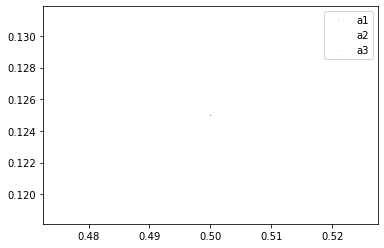

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.plot(x[:,0],y,'*', markersize=0.1)
plt.legend(['a1','a2','a3'])
plt.show()
#out = plt.scatter(x[:,0], x[:,1], s=6, c=y, cmap=cm.hot, vmin=0, vmax=1.2)
#plt.show()


--------------




Creating Models
------------------
To define a neural network in PyTorch, we create a class that inherits
from `nn.Module <https://pytorch.org/docs/stable/generated/torch.nn.Module.html>`_. We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



Read more about `building neural networks in PyTorch <buildmodel_tutorial.html>`_.




--------------




In [8]:
# create network
import torch
print(torch.__version__)
# define the network
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class DLRANet_Regression(nn.Module):
    weights_K:list[torch.Tensor]  # n1 x r
    weights_Lt:list[torch.Tensor] # n2 x r
    weights_S:list[torch.Tensor]  # r x r
    aux_U:list[torch.Tensor]      # n1 x r
    aux_Unp1:list[torch.Tensor]   # n1 x r
    aux_Vt:list[torch.Tensor]     # r x n2
    aux_Vtnp1:list[torch.Tensor]  # r x n2
    aux_N:list[torch.Tensor]      # r x r
    aux_M:list[torch.Tensor]      # r x r
    biases:list[torch.Tensor]     # n2
    acts:list                     # activation functions
    num_layers:int 
    layer_width:int
    
    def __init__(self,input_dim:int,output_dim:int,layer_width:int,num_layers:int,low_rank:int=10):
        self.num_layers = num_layers
        self.layer_width = layer_width
        # weight initialization
        W = torch.rand(input_dim,layer_width)
        W = W/torch.norm(W)
        #print(W.size())
        u, s, v = torch.svd(W)
        #print(W)
        #print(torch.mm(u,torch.mm(torch.diag(s),torch.transpose(v,0,1))))
        #print(torch.mm(torch.narrow(u, 1, 0, low_rank),torch.mm(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank),torch.narrow(torch.transpose(v,0,1), 0, 0, low_rank))))
        #print(torch.mm(torch.narrow(u, 1, 0, low_rank),torch.mm(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank),torch.narrow(torch.transpose(v,0,1), 0, 0, low_rank)))-W)
        #print(u.size())
        #print(s.size())
        #print(v.size())
        #t = torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank)
        #print(t)
        vt=torch.transpose(v,0,1)
        low_rank_input = min(input_dim,low_rank)
        self.weights_K:list[torch.Tensor] = [torch.rand(input_dim,low_rank_input)]    # gets overwritten in K-step
        self.weights_Lt:list[torch.Tensor] = [torch.rand(layer_width,low_rank_input)] # gets overwritten in L-step
        self.weights_S:list[torch.Tensor] = [torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank_input) , 1, 0, low_rank_input)]       # narrow to rxr
        self.aux_U:list[torch.Tensor] = [torch.narrow(u, 1, 0, low_rank_input)]      # narrow to n2xr
        self.aux_Unp1:list[torch.Tensor] = [torch.rand(input_dim,low_rank_input)]     # gets overwritten 
        self.aux_Vt:list[torch.Tensor] = [torch.narrow(vt, 0, 0, low_rank_input)]    # narrow to rxn1
        self.aux_Vtnp1:list[torch.Tensor] = [torch.rand(low_rank_input,layer_width)]   # gets overwritten 
        self.aux_N:list[torch.Tensor] = [torch.rand(low_rank_input,low_rank_input)]  # gets overwritten 
        self.aux_M:list[torch.Tensor] = [torch.rand(low_rank_input,low_rank_input)]  # gets overwritten 
        self.biases:list[torch.Tensor] = [torch.rand(layer_width)]       
        self.acts:list[torch.nn.ReLU]=[torch.nn.ReLU()]
        for i in range(1,num_layers-1):
            # weight initialization
            self.W = torch.rand(layer_width,layer_width)
            self.W = self.W/torch.norm(self.W)
            u, s, v = torch.svd(self.W)
            vt=torch.transpose(v,0,1)
            self.weights_K.append(torch.rand(layer_width,low_rank, requires_grad=True))
            self.weights_Lt.append(torch.rand(layer_width,low_rank, requires_grad=True))
            self.weights_S.append(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank) , 1, 0, low_rank))
            self.aux_U.append(torch.narrow(u, 1, 0, low_rank))
            self.aux_Unp1.append(torch.rand(layer_width,low_rank, requires_grad=False))
            self.aux_Vt.append(torch.narrow(vt, 0, 0, low_rank))
            self.aux_Vtnp1.append(torch.rand(low_rank,layer_width, requires_grad=False))
            self.aux_N.append(torch.rand(low_rank,low_rank, requires_grad=False))
            self.aux_M.append(torch.rand(low_rank,low_rank, requires_grad=False))
            self.biases.append(torch.rand(layer_width, requires_grad=True))
            self.acts.append(torch.nn.ReLU())

        W = torch.rand(layer_width,output_dim)
        W = W/torch.norm(W)
        u, s, v = torch.svd(W)
        vt=torch.transpose(v,0,1)
        low_rank_output = min(output_dim,low_rank)
        self.weights_K.append(torch.rand(layer_width,low_rank_output, requires_grad=True))
        self.weights_Lt.append(torch.rand(output_dim,low_rank_output, requires_grad=True))
        self.weights_S.append(torch.narrow(torch.narrow(torch.diag(s), 0, 0, low_rank_output) , 1, 0, low_rank_output))
        self.aux_U.append(torch.narrow(u, 1, 0, low_rank_output))
        self.aux_Unp1.append(torch.rand(layer_width,low_rank_output, requires_grad=False))
        self.aux_Vt.append(torch.narrow(vt, 0, 0, low_rank_output))
        self.aux_Vtnp1.append(torch.rand(low_rank_output,output_dim, requires_grad=False))
        self.aux_N.append(torch.rand(low_rank_output,low_rank, requires_grad=False))
        self.aux_M.append(torch.rand(low_rank_output,low_rank, requires_grad=False))
        self.biases.append(torch.rand(output_dim, requires_grad=True))
        self.acts.append(torch.nn.Identity()) # last layer with identity output

        with torch.no_grad():
            for i in range(0,self.num_layers):
                # mark for auto differentiation tape
                self.weights_K[i].requires_grad = True
                self.weights_Lt[i].requires_grad = True
                self.weights_S[i].requires_grad = True
                self.aux_U[i].requires_grad = False
                self.aux_Vt[i].requires_grad = False
                self.aux_N[i].requires_grad = False
                self.aux_M[i].requires_grad = False
                self.biases[i].requires_grad = True
        return None
    
    def K_step_forward(self,input_tensor:torch.Tensor)->torch.Tensor:
        # K-step of DRLA (forward pass)
        # prepare  K 
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # a) update K
                self.weights_K[i] = torch.matmul(self.aux_U[i],self.weights_S[i])
                self.weights_K[i].requires_grad = True
        z = input_tensor
        # pass forward
        for i in range(0,self.num_layers):
            #z = f(xW+b) = f(xKV + b)
            z = self.acts[i](torch.matmul(z,torch.matmul(self.weights_K[i],self.aux_Vt[i])))

        return z
    
    def K_step_update(self,stepsize:float=1e-3):
        # K-step of DRLA (update)
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # gradient update
                self.weights_K[i]=self.weights_K[i]- stepsize* self.weights_K[i].grad
                self.weights_K[i].requires_grad = True
                # Create U
                self.aux_Unp1[i],_ = torch.qr(self.weights_K[i])
                #print(self.weights_K[i].size())
                #print(t.size())
                #print("unp1")
                #print(self.aux_Unp1[i].size())
                #print("U")
                #print(self.aux_U[i].size())
                #print("prod")
                #tmp = torch.matmul(torch.transpose(self.aux_Unp1[i], 0, 1),self.aux_U[i])
                #print(tmp.size())
                #print("____")
                # Create N
                self.aux_N[i] = torch.matmul(torch.transpose(self.aux_Unp1[i], 0, 1),self.aux_U[i])
        return None
    
    def L_step_forward(self,input_tensor:torch.Tensor)->torch.Tensor:
        # L-step of DLRA (forward)
        # prepare  L 
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # a) update L
                self.weights_Lt[i] = torch.matmul(self.weights_S[i],self.aux_Vt[i]) # L-transpose 
                self.weights_Lt[i].requires_grad = True
        z = input_tensor
        # pass forward
        for i in range(0,self.num_layers):
            #z = f(xW+b) = f(xUL + b)
            z =self.acts[i](torch.matmul(z,torch.matmul(self.aux_U[i],self.weights_Lt[i])))
        return z
     
    def L_step_update(self,stepsize:float=1e-3):
        # L-step of DRLA (update)
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # gradient update
                self.weights_Lt[i]=self.weights_Lt[i]- stepsize* self.weights_Lt[i].grad
                self.weights_Lt[i].requires_grad = True
                # Create V_np1
                self.aux_Vtnp1[i], _ = torch.qr(torch.transpose(self.weights_Lt[i], 0, 1))
                self.aux_Vtnp1[i] = torch.transpose(self.aux_Vtnp1[i], 0, 1)
                # Create N
                #print("S")
                #print(self.weights_S[i].size())
                #print("V")
                #print(self.aux_Vt[i].size())
                #print("L")
                #print(self.weighweights_Ltts_L[i].size())
                #print("Vnp1")
                #print(self.aux_Vtnp1[i].size())
                #print("V")
                #print(self.aux_Vt[i].size())
                #print("prod")
                #tmp =  torch.matmul(self.aux_Vtnp1[i],torch.transpose(self.aux_Vt[i], 0, 1))
                #print(tmp.size())
                #print("____")
                self.aux_M[i] = torch.matmul(self.aux_Vtnp1[i],torch.transpose(self.aux_Vt[i], 0, 1)) #Vtnp1*V
                # Update U_np1
                #self.aux_U[i] = U_np1
        return None
    
    def S_step_forward(self,input_tensor:torch.Tensor)->torch.Tensor:
        # S-step of DLRA (forward)
        # prepare  S
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # a) update S
                self.weights_S[i] = torch.matmul(torch.matmul(self.aux_N[i],self.weights_S[i]),torch.transpose(self.aux_M[i], 0, 1)) # S
                self.weights_S[i].requires_grad = True
        
        z = input_tensor
        # pass forward
        for i in range(0,self.num_layers):
            #z = f(xW+b) \approx f(xUnp1 S Vnp1^T + b)
            z = self.acts[i](torch.matmul(z,torch.matmul(self.aux_Unp1[i],torch.matmul(self.weights_S[i],self.aux_Vtnp1[i]))))
        #print(self.W.size())
        #print(self.W)
        #t = torch.matmul(self.aux_Unp1[self.num_layers-2],torch.matmul(self.weights_S[self.num_layers-2],self.aux_Vtnp1[self.num_layers-2]))
        #print(t.size())
        #print(t)
        #print("____")
        return z
     
    def S_step_update(self,stepsize:float=1e-3):
        # S-step of DRLA (update)
        with torch.no_grad():
            for i in range(0,self.num_layers):
                # gradient update
                self.weights_S[i]=self.weights_S[i]- stepsize* self.weights_S[i].grad
                self.weights_S[i].requires_grad = True
                # update U to Unp1 and V to Vnp1
                self.aux_U[i] = self.aux_Unp1[i]
                self.aux_Vt[i] = self.aux_Vtnp1[i]
        return None
    
    def clear_grads(self):
        #print("Clear Grads")
        for i in range(0,self.num_layers):
            if self.weights_K[i].grad is not None:
                self.weights_K[i].grad.data.zero_()
            if self.weights_Lt[i].grad is not None:
                self.weights_Lt[i].grad.data.zero_()
            if self.weights_S[i].grad is not None:
                self.weights_S[i].grad.data.zero_()
            if self.aux_U[i].grad is not None:
                self.aux_U[i].grad.data.zero_()
            if self.aux_Unp1[i].grad is not None:
                self.aux_Unp1[i].grad.data.zero_()
            if self.aux_Vt[i].grad is not None:
                self.aux_Vt[i].grad.data.zero_()
            if self.aux_Vtnp1[i].grad is not None:
                self.aux_Vtnp1[i].grad.data.zero_()
            if self.aux_N[i].grad is not None:
                self.aux_N[i].grad.data.zero_()
            if self.aux_M[i].grad is not None:
                self.aux_M[i].grad.data.zero_()
            if self.biases[i].grad is not None:
                self.biases[i].grad.data.zero_()
        return None
        
    def print_layer_size(self):
         for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print("K")
            print(self.weights_K[i].size())
            print("Lt")
            print(self.weights_Lt[i].size())
            print("S")
            print(self.weights_S[i].size())
            print("U")
            print(self.aux_U[i].size())
            print("Unp1")
            print(self.aux_Unp1[i].size())
            print("Vt")
            print(self.aux_Vt[i].size())
            print("Vtnp1")
            print(self.aux_Vtnp1[i].size())
            print("N")
            print(self.aux_N[i].size())
            print("M")
            print(self.aux_M[i].size())
            print("b")
            print(self.biases[i].size())
    
    def print_layer_weights(self):
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print("K")
            print(self.weights_K[i])
            print("L")
            print(self.weights_Lt[i])
            print("S")
            print(self.weights_S[i])
            print("U")
            print(self.aux_U[i])
            print("Unp1")
            print(self.aux_Unp1[i])
            print("Vt")
            print(self.aux_Vt[i])
            print("Vtnp1")
            print(self.aux_Vtnp1[i])
            print("N")
            print(self.aux_N[i])
            print("M")
            print(self.aux_M[i])
            print("b")
            print(self.biases[i])
        return None
    
    def print_layer_grads_K(self):
        print("K")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_K[i].grad.size())
            print(self.weights_K[i].grad)

        return None
    
    def print_layer_grads_L(self):
        print("L")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_Lt[i].grad.size())
            print(self.weights_Lt[i].grad)
        return None
    
    def print_layer_grads_S(self):
        print("S")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_S[i].grad.size())
            print(self.weights_S[i].grad)
        return None
    
    def print_weights_K(self):
        print("K")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_K[i])
            
    def print_weights_Lt(self):
        print("L")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_Lt[i])
            
    def print_weights_S(self):
        print("S")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.weights_S[i])
    
    def print_aux_M(self):
        print("M")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.aux_M[i])
    
    def print_aux_N(self):
        print("N")
        for i in range(0,self.num_layers):
            print("layer "+ str(i))
            print(self.aux_N[i])
    

1.7.1
Using cpu device


test untrained network


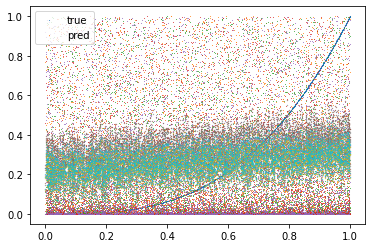

In [9]:
## some sanity checks 
loss_fn =  torch.nn.functional.mse_loss

dim_in= problem_dim
dim_out = problem_dim
layer_width = 30
layer_num = 4
low_rank = 10
test_net = DLRANet_Regression(dim_in,dim_out,layer_width,layer_num,low_rank)
#test_net.print_layer_size()
#test_net.print_layer_size()

print("test untrained network")
# test the network
xtest = np.random.rand(6000,problem_dim)
ytest = np.linalg.norm(x,axis=1,keepdims=True)*np.linalg.norm(x,axis=1,keepdims=True)
ytest = target_fun(xtest)
pred = test_net.K_step_forward(torch.tensor(xtest).float())

pred_np = pred.detach().numpy()

plt.plot(xtest[:,0],ytest,'*', markersize=0.2)
plt.plot(xtest[:,0],pred_np,'o', markersize=0.3)

plt.legend(['true','pred'])
plt.show()
#print(pred_np)



In [10]:
print("layer size")
#test_net.print_layer_size()
print("layer weights")
#test_net.print_layer_weights()
x1 = torch.tensor(x).float()
y1 = torch.tensor(y).float()


layer size
layer weights


In [11]:
print("K_step")
out = test_net.K_step_forward(x1)
print("output")
print(out.size())
loss = loss_fn(out, y1)

print("loss")
print(loss.size())
print(loss)
loss.backward()
test_net.K_step_update(stepsize=1e-2)
test_net.clear_grads()

K_step
output
torch.Size([1, 5])
loss
torch.Size([])
tensor(0.0247, grad_fn=<MseLossBackward>)


In [12]:
print("L_step_forward")
out = test_net.L_step_forward(x1)
print("output")
print(out.size())
loss = loss_fn(out, y1)
print("loss")
print(loss.size())
print(loss)
loss.backward()
test_net.L_step_update(stepsize=1e-2)
test_net.clear_grads()

L_step_forward
output
torch.Size([1, 5])
loss
torch.Size([])
tensor(0.0247, grad_fn=<MseLossBackward>)


In [13]:
print("S_step_forward")
out = test_net.S_step_forward(x1)
print("output")
print(out.size())
loss = loss_fn(out, y1)
print("loss")
print(loss.size())
print(loss)
loss.backward()
test_net.S_step_update(stepsize=1e-2)
test_net.clear_grads()

S_step_forward
output
torch.Size([1, 5])
loss
torch.Size([])
tensor(0.0247, grad_fn=<MseLossBackward>)


# Define Network for MNIST

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



We also check the model's performance against the test dataset to ensure it is learning.



The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



Read more about `Training your model <optimization_tutorial.html>`_.




--------------




In [14]:
losses_S =[]
losses_K =[]
losses_L =[]

def test_toy(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    #model.eval()
    test_lossS,test_lossK,test_lossL, correct = 0, 0, 0, 0
    with torch.no_grad():
        for batch, sample in enumerate(dataloader):
            X=sample["X_data"]
            Y=sample["Y_data"]
        
            x, y = X.to(device).float(), Y.to(device).float()
            ## K-Step ##
            pred = model.K_step_forward(x)
            test_lossK += loss_fn(pred, y).item()
            ## L-Step ##
            pred = model.L_step_forward(x)
            test_lossL += loss_fn(pred, y).item()  
            ## S-Step ##
            pred = model.S_step_forward(x)
            test_lossS += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_lossS /= num_batches
    losses_S.append(test_lossS)
    test_lossK /= num_batches
    losses_K.append(test_lossK)
    test_lossL /= num_batches
    losses_L.append(test_lossL)

    print(f"Test Error:%, Avg loss K: {test_lossK:>8f}, Avg loss L: {test_lossL:>8f},Avg loss S: {test_lossS:>8f} \n")

In [15]:

def train_toy(dataloader, model, loss_fn,stepsize_cur):
    size = len(dataloader.dataset)
    #model.train()
    for batch, sample in enumerate(dataloader):
        
        X=sample["X_data"]
        Y=sample["Y_data"]
        
        x, y = X.to(device).float(), Y.to(device).float()
        #print(x.size())
        #print(y.size())
        #x = nn.Flatten()(X)
       
        # Compute prediction error
        
        ## K-Step ##
        #print("K-Step")
        out = model.K_step_forward(x)
        #print(out.size())
        #print("___")
        loss = loss_fn(out, y)
        #print(loss)
        loss.backward()
        #model.print_layer_grads_K()
        model.K_step_update(stepsize=stepsize_cur)
        #model.print_weights_K()
        model.clear_grads()
        ## L-Step ##
        #print("L-Step")
        out = model.L_step_forward(x)
        loss = loss_fn(out, y)
        #print(loss)
        loss.backward()
        #model.print_layer_grads_L()
        model.L_step_update(stepsize=stepsize_cur)
        #model.print_weights_Lt()
        model.clear_grads()

        ## S-Step ##
        #print("S-Step")
        out = model.S_step_forward(x)
        #model.print_weights_S()
        loss = loss_fn(out, y)
        #print(loss)
        loss.backward()
        #model.print_layer_grads_S()

        #model.print_weights_S()
        #model.print_aux_M()
        #model.print_aux_N()
        model.S_step_update(stepsize=stepsize_cur)
        model.clear_grads()
        

        #print(model.weights[1])
        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [17]:
## Define network
batch_size = 128
dim_in= problem_dim
dim_out = problem_dim
layer_width = 100
layer_num = 3
low_rank = 20
model = DLRANet_Regression(dim_in,dim_out,layer_width,layer_num,low_rank)
loss_fn =  torch.nn.functional.mse_loss


In [18]:
epochs =100
batch_size =512
stepsize=1e-1
train_dataloader = DataLoader(ToyDataset, batch_size=batch_size)
test_dataloader = DataLoader(ToyDataset_Test, batch_size=batch_size)

for t in range(epochs):
    #model.print_layer_size()
    #model.print_layer_weights()
    print(f"Epoch {t+1}\n-------------------------------")
    stepsize_cur = stepsize#/(t+1)
    print("Stepsize: "+str(stepsize_cur))
    train_toy(train_dataloader, model, loss_fn,stepsize_cur)
    test_toy(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.033726, Avg loss L: 0.033726,Avg loss S: 0.033716 

Epoch 2
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.028514, Avg loss L: 0.028514,Avg loss S: 0.028504 

Epoch 3
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.024356, Avg loss L: 0.024356,Avg loss S: 0.024416 

Epoch 4
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.021045, Avg loss L: 0.021045,Avg loss S: 0.021026 

Epoch 5
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.018261, Avg loss L: 0.018261,Avg loss S: 0.018321 

Epoch 6
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.016016, Avg loss L: 0.016016,Avg loss S: 0.015985 

Epoch 7
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.014056, Avg loss L: 0.014056,Avg loss S: 0.014135 

Epoch 8
-------------------------------
Stepsize: 0.1
Test Err

Test Error:%, Avg loss K: 0.015406, Avg loss L: 0.015406,Avg loss S: 0.016261 

Epoch 79
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.016206, Avg loss L: 0.016206,Avg loss S: 0.016204 

Epoch 80
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.016192, Avg loss L: 0.016192,Avg loss S: 0.024181 

Epoch 81
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.023913, Avg loss L: 0.023913,Avg loss S: 0.020565 

Epoch 82
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.020449, Avg loss L: 0.020449,Avg loss S: 0.012008 

Epoch 83
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.011893, Avg loss L: 0.011893,Avg loss S: 0.020158 

Epoch 84
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.019995, Avg loss L: 0.019995,Avg loss S: 0.014255 

Epoch 85
-------------------------------
Stepsize: 0.1
Test Error:%, Avg loss K: 0.014220, Avg loss L: 0.01422

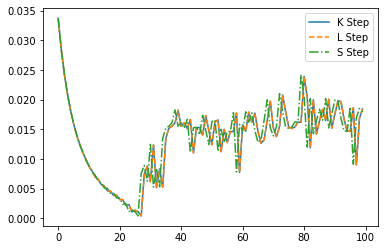

In [22]:
plt.plot(range(0,len(losses_K)),losses_K)
plt.plot(range(0,len(losses_K)),losses_L,'--')
plt.plot(range(0,len(losses_K)),losses_S,'-.')
plt.legend(["K Step","L Step", "S Step"])

In [23]:
# test the network
#x = np.random.rand(6000,problem_dim)
#y = np.linalg.norm(x,axis=1,keepdims=True)*np.linalg.norm(x,axis=1,keepdims=True)
#y = y*y
pred = model.K_step_forward(torch.tensor(x).float())

pred_np = pred.detach().numpy()

In [24]:
print(x)
print(y)
print(pred_np)

[[0.5 0.5 0.5 0.5 0.5]]
[[0.125 0.125 0.125 0.125 0.125]]
[[-0.07061374 -0.01027245  0.01276177  0.02339957  0.02402029]]


In [ ]:
plt.plot(x[:,0],y,'*', markersize=0.2)
plt.plot(x[:,0],pred_np,'*', markersize=0.2)

plt.legend(['true','pred'])
plt.show()